# Exercises:
### 1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

### 2. Answer those questions through a mix of statistical tests and visualizations.


## Bonus:

#### Compute the mean(logerror) by zipcode and the overall mean(logerror). 
#### Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# For statistical modeling
import scipy.stats as stats

import random

# To acquire MYSQL Data
import acquire
from env import username, password, host
from cluster_wrangle import scale_data, train_validate_test, wrangle_zillow, remove_outliers, rfe, rmse, pf
from cluster_wrangle import lasso_lars, glm, pf_test, value_viz, pred_act, no_error, test, vis, graph, split, n_error
import cluster_eval

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# To avoid deprecation and other warnings
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

# Questions:
### 1. Because LA county comprises over half of the data, is the model 'good' to use for the othe counties?
    - 
### 2. If the 'outlier data' was reintroduced, could the utility of our model increase when using a clustering method?
    - Didn't use clustering, but the results were much different with all the data(also the imputes were different
### 3. Is the zip code or census tract feature better at predicting value?
    - 
### 4. What's the distribution of building material quality to prices?
    - 
### 5. What's the variance between structuretax and landtax?
    -

---

In [2]:
# Data saved to a csv. from a SQL query
zillow = pd.read_csv('zillow_2017_w_transactiondate.csv')
zillow.head()

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,4,266.0,10887214,1970746,1.0,NaN,NaN,3.0,3.0,NaN,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,0.006940,2017-01-01,Condominium


In [3]:
zillow = zillow[zillow.propertylandusedesc == 'Single Family Residential']
zillow.head()

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
6,6,261.0,12095076,781532,1.0,NaN,NaN,3.0,4.0,NaN,...,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,6,-0.001011,2017-01-01,Single Family Residential


In [4]:
zillow['month'] = zillow['transactiondate'].str[5:7]
zillow['transactiondate'] = zillow['transactiondate'].str[:4]
zillow

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc,month
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017,Single Family Residential,01
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017,Single Family Residential,01
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017,Single Family Residential,01
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017,Single Family Residential,01
6,6,261.0,12095076,781532,1.0,NaN,NaN,3.0,4.0,NaN,...,496619.0,9516.26,NaN,NaN,6.037461e+13,6,-0.001011,2017,Single Family Residential,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,77575,261.0,11000655,673515,NaN,NaN,NaN,2.0,2.0,NaN,...,283704.0,4478.43,NaN,NaN,6.037101e+13,77609,0.020615,2017,Single Family Residential,09
77576,77576,261.0,17239384,2968375,NaN,NaN,NaN,2.0,4.0,NaN,...,16522.0,1107.48,NaN,NaN,6.111008e+13,77610,0.013209,2017,Single Family Residential,09
77577,77577,261.0,12773139,1843709,1.0,NaN,NaN,1.0,3.0,NaN,...,16749.0,876.43,NaN,NaN,6.037434e+13,77611,0.037129,2017,Single Family Residential,09
77578,77578,261.0,12826780,1187175,NaN,NaN,NaN,2.0,3.0,NaN,...,382000.0,6317.15,NaN,NaN,6.037503e+13,77612,0.007204,2017,Single Family Residential,09


In [5]:
zillow = zillow[zillow.transactiondate == '2017']

In [6]:
# Reassign the df to only the values where the home had a transaction in 2017
zillow = zillow[['parcelid','bathroomcnt', 'bedroomcnt','buildingqualitytypeid', 'calculatedfinishedsquarefeet','fips',
                 'lotsizesquarefeet', 'regionidzip', 'taxvaluedollarcnt', 'month', 'heatingorsystemtypeid', 'latitude',
                 'longitude', 'rawcensustractandblock', 'censustractandblock', 'roomcnt', 'unitcnt', 'yearbuilt',
                 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'logerror']]
parcelid = zillow.parcelid
zillow = zillow.drop(columns={'parcelid'})
zillow.rename(columns={'bedroomcnt':'bedrooms',
                   'bathroomcnt':'bathrooms', 
                   'calculatedfinishedsquarefeet':'f_sqft', 
                   'taxvaluedollarcnt':'tax_value',
                   'lotsizesquarefeet':'lot_size',
                   'regionidzip':'zip',
                   'buildingqualitytypeid':'bldg_quality'}, inplace=True)

In [7]:
zillow.head()

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,zip,tax_value,month,heatingorsystemtypeid,...,rawcensustractandblock,censustractandblock,roomcnt,unitcnt,yearbuilt,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount,calculatedbathnbr,logerror
0,3.5,4.0,NaN,3100.0,6059.0,4506.0,96978.0,1023282.0,01,NaN,...,6.059063e+07,6.059063e+13,0.0,NaN,1998.0,537569.0,485713.0,11013.72,3.5,0.025595
1,1.0,2.0,NaN,1465.0,6111.0,12647.0,97099.0,464000.0,01,NaN,...,6.111001e+07,6.111001e+13,5.0,NaN,1967.0,376000.0,88000.0,5672.48,1.0,0.055619
2,2.0,3.0,NaN,1243.0,6059.0,8432.0,97078.0,564778.0,01,NaN,...,6.059022e+07,6.059022e+13,6.0,NaN,1962.0,479489.0,85289.0,6488.30,2.0,0.005383
3,3.0,4.0,8.0,2376.0,6037.0,13038.0,96330.0,145143.0,01,2.0,...,6.037300e+07,6.037300e+13,0.0,1.0,1970.0,36225.0,108918.0,1777.51,3.0,-0.103410
6,3.0,4.0,9.0,2962.0,6037.0,63000.0,96293.0,773303.0,01,2.0,...,6.037461e+07,6.037461e+13,0.0,1.0,1950.0,496619.0,276684.0,9516.26,3.0,-0.001011


In [8]:
#zillow.replace({6037.0: 'LA', 6059.0: 'Ventura', 6111.0: 'Orange'}, inplace=True)

In [9]:
zillow.head()

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,zip,tax_value,month,heatingorsystemtypeid,...,rawcensustractandblock,censustractandblock,roomcnt,unitcnt,yearbuilt,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount,calculatedbathnbr,logerror
0,3.5,4.0,NaN,3100.0,6059.0,4506.0,96978.0,1023282.0,01,NaN,...,6.059063e+07,6.059063e+13,0.0,NaN,1998.0,537569.0,485713.0,11013.72,3.5,0.025595
1,1.0,2.0,NaN,1465.0,6111.0,12647.0,97099.0,464000.0,01,NaN,...,6.111001e+07,6.111001e+13,5.0,NaN,1967.0,376000.0,88000.0,5672.48,1.0,0.055619
2,2.0,3.0,NaN,1243.0,6059.0,8432.0,97078.0,564778.0,01,NaN,...,6.059022e+07,6.059022e+13,6.0,NaN,1962.0,479489.0,85289.0,6488.30,2.0,0.005383
3,3.0,4.0,8.0,2376.0,6037.0,13038.0,96330.0,145143.0,01,2.0,...,6.037300e+07,6.037300e+13,0.0,1.0,1970.0,36225.0,108918.0,1777.51,3.0,-0.103410
6,3.0,4.0,9.0,2962.0,6037.0,63000.0,96293.0,773303.0,01,2.0,...,6.037461e+07,6.037461e+13,0.0,1.0,1950.0,496619.0,276684.0,9516.26,3.0,-0.001011


In [10]:
#zillow = zillow.drop(columns={'fips'})
#zillow.replace({'Orange': 6111.0}, inplace=True)

In [11]:
#train, validate, test = split(zillow)

In [12]:
#train.head()

In [13]:
#sns.relplot(data=train, x='latitude', y= 'longitude', hue='zip')
#plt.title('County Values by Latitude and Longitude')
#plt.show()

In [14]:
#train.tax_value.value_counts(bins=20, sort=False)

In [15]:
#sns.relplot(data=train, x='latitude', y= 'longitude', hue='tax_value')
#plt.show()

In [16]:
#len(train)

In [17]:
#train[train.tax_value > 0]

In [18]:
#(train[train.tax_value > 0]).value_counts()

In [19]:
#train.tax_value.value_counts(sort=False)

In [20]:
#sns.histplot(data=train, x='tax_value', y= 'fips')
#plt.show()

In [21]:
#(train == 'Orange').sum()

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
zillow

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,zip,tax_value,month,heatingorsystemtypeid,...,rawcensustractandblock,censustractandblock,roomcnt,unitcnt,yearbuilt,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount,calculatedbathnbr,logerror
0,3.5,4.0,NaN,3100.0,6059.0,4506.0,96978.0,1023282.0,01,NaN,...,6.059063e+07,6.059063e+13,0.0,NaN,1998.0,537569.0,485713.0,11013.72,3.5,0.025595
1,1.0,2.0,NaN,1465.0,6111.0,12647.0,97099.0,464000.0,01,NaN,...,6.111001e+07,6.111001e+13,5.0,NaN,1967.0,376000.0,88000.0,5672.48,1.0,0.055619
2,2.0,3.0,NaN,1243.0,6059.0,8432.0,97078.0,564778.0,01,NaN,...,6.059022e+07,6.059022e+13,6.0,NaN,1962.0,479489.0,85289.0,6488.30,2.0,0.005383
3,3.0,4.0,8.0,2376.0,6037.0,13038.0,96330.0,145143.0,01,2.0,...,6.037300e+07,6.037300e+13,0.0,1.0,1970.0,36225.0,108918.0,1777.51,3.0,-0.103410
6,3.0,4.0,9.0,2962.0,6037.0,63000.0,96293.0,773303.0,01,2.0,...,6.037461e+07,6.037461e+13,0.0,1.0,1950.0,496619.0,276684.0,9516.26,3.0,-0.001011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77573,2.0,4.0,6.0,1633.0,6037.0,4630.0,96204.0,346534.0,09,2.0,...,6.037555e+07,6.037555e+13,0.0,1.0,1962.0,221068.0,125466.0,4175.08,2.0,0.001082
77575,2.0,2.0,6.0,1286.0,6037.0,47405.0,96284.0,354621.0,09,2.0,...,6.037101e+07,6.037101e+13,0.0,1.0,1940.0,283704.0,70917.0,4478.43,2.0,0.020615
77576,2.0,4.0,NaN,1612.0,6111.0,12105.0,97116.0,67205.0,09,NaN,...,6.111008e+07,6.111008e+13,7.0,NaN,1964.0,16522.0,50683.0,1107.48,2.0,0.013209
77577,1.0,3.0,4.0,1032.0,6037.0,5074.0,96480.0,49546.0,09,2.0,...,6.037434e+07,6.037434e+13,0.0,1.0,1954.0,16749.0,32797.0,876.43,1.0,0.037129


In [24]:
zillow.columns

Index(['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'fips', 'lot_size',
       'zip', 'tax_value', 'month', 'heatingorsystemtypeid', 'latitude',
       'longitude', 'rawcensustractandblock', 'censustractandblock', 'roomcnt',
       'unitcnt', 'yearbuilt', 'landtaxvaluedollarcnt',
       'structuretaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr',
       'logerror'],
      dtype='object')

In [25]:
zillow.isnull().sum()

bathrooms                         0
bedrooms                          0
bldg_quality                  18701
f_sqft                           82
fips                              0
lot_size                        369
zip                              26
tax_value                         1
month                             0
heatingorsystemtypeid         18506
latitude                          0
longitude                         0
rawcensustractandblock            0
censustractandblock             123
roomcnt                           0
unitcnt                       18594
yearbuilt                       116
landtaxvaluedollarcnt             1
structuretaxvaluedollarcnt       84
taxamount                         4
calculatedbathnbr               137
logerror                          0
dtype: int64

## Modeling on more data

In [26]:
def scale(df, columns=['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'lot_size', 'zip',
       'month', 'heatingorsystemtypeid', 'latitude', 'longitude',
       'rawcensustractandblock', 'censustractandblock', 'roomcnt', 'unitcnt',
       'yearbuilt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt',
       'taxamount', 'calculatedbathnbr', 'logerror'], target='tax_value', return_scaler=False):
    '''
    Scales train, validate, test and returns scaled versions of each 
    If return_scalar is True, the scaler object will be returned as well
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=0.2, random_state=248)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=248)

    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = pd.DataFrame(train[target])

    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = pd.DataFrame(validate[target])

    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = pd.DataFrame(test[target])
    
    # make copies
    train_scaled = X_train.copy()
    validate_scaled = X_validate.copy()
    test_scaled = X_test.copy()
    # Make the scaler
    scaler = MinMaxScaler()
    # Fit it
    scaler.fit(X_train[columns])
    # Apply the scaler:
    train_scaled[columns] = pd.DataFrame(scaler.transform(X_train[columns]),
                                                  columns=X_train[columns].columns.values).set_index([X_train.index.values])
                                                  
    validate_scaled[columns] = pd.DataFrame(scaler.transform(X_validate[columns]),
                                                  columns=X_validate[columns].columns.values).set_index([X_validate.index.values])
    
    test_scaled[columns] = pd.DataFrame(scaler.transform(X_test[columns]),
                                                 columns=X_test[columns].columns.values).set_index([X_test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test


In [27]:
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = scale(zillow, columns=['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'lot_size', 'zip',
       'month', 'heatingorsystemtypeid', 'latitude', 'longitude',
       'rawcensustractandblock', 'censustractandblock', 'roomcnt', 'unitcnt',
       'yearbuilt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt',
       'taxamount', 'calculatedbathnbr', 'logerror'], target='tax_value')

In [28]:
y_train.isnull().sum()

tax_value    0
dtype: int64

In [29]:
y_validate.isnull().sum()

tax_value    1
dtype: int64

In [30]:
y_validate.median()

tax_value    375605.0
dtype: float64

In [31]:
y_validate.tax_value.fillna(375605.0, inplace=True)

In [32]:
rmse(y_train, y_validate, 'tax_value')

R̲M̲S̲E

Using Mean:
Train(In-Sample):        776664
Validate(Out-of-Sample): 699685

Using Median:
Train(In-Sample):        792326
Validate(Out-of-Sample): 716180


In [33]:
y_test.isnull().sum()

tax_value    0
dtype: int64

In [34]:
train_scaled.isnull().sum()

bathrooms                         0
bedrooms                          0
bldg_quality                  10445
f_sqft                           42
fips                              0
lot_size                        209
zip                              14
month                             0
heatingorsystemtypeid         10349
latitude                          0
longitude                         0
rawcensustractandblock            0
censustractandblock              61
roomcnt                           0
unitcnt                       10386
yearbuilt                        64
landtaxvaluedollarcnt             0
structuretaxvaluedollarcnt       36
taxamount                         3
calculatedbathnbr                68
logerror                          0
dtype: int64

In [35]:
train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,29366.0,0.127926,0.056618,0.0,0.111111,0.111111,0.166667,1.0
bedrooms,29366.0,0.235946,0.067750,0.0,0.214286,0.214286,0.285714,1.0
bldg_quality,18921.0,0.478968,0.155788,0.0,0.363636,0.454545,0.636364,1.0
f_sqft,29324.0,0.088915,0.054238,0.0,0.053414,0.074758,0.109822,1.0
fips,29366.0,6049.097255,21.002644,6037.0,6037.000000,6037.000000,6059.000000,6111.0
lot_size,29157.0,0.001568,0.011201,0.0,0.000767,0.000947,0.001224,1.0
zip,29352.0,0.002164,0.015474,0.0,0.000731,0.001422,0.003336,1.0
month,29366.0,0.509812,0.293255,0.0,0.250000,0.500000,0.750000,1.0
heatingorsystemtypeid,19017.0,0.155354,0.134938,0.0,0.052632,0.052632,0.315789,1.0
latitude,29366.0,0.461823,0.185544,0.0,0.329410,0.462373,0.572336,1.0


In [36]:
# just goin to impute the mean
train_scaled.bldg_quality.fillna(0.478968, inplace=True)
train_scaled.f_sqft.fillna(0.088915, inplace=True)
train_scaled.lot_size.fillna(0.001568, inplace=True)
train_scaled.zip.fillna(0.002164, inplace=True)
train_scaled.heatingorsystemtypeid.fillna(0.155354, inplace=True)
train_scaled.censustractandblock.fillna(0.000325, inplace=True)
train_scaled.unitcnt.fillna(0.000948, inplace=True)
train_scaled.yearbuilt.fillna(0.618288, inplace=True)
train_scaled.structuretaxvaluedollarcnt.fillna(0.025063, inplace=True)
train_scaled.taxamount.fillna(0.010923, inplace=True)
train_scaled.calculatedbathnbr.fillna(0.076912, inplace=True)

In [37]:
validate_scaled.isnull().sum()

bathrooms                        0
bedrooms                         0
bldg_quality                  4524
f_sqft                          22
fips                             0
lot_size                        89
zip                              8
month                            0
heatingorsystemtypeid         4471
latitude                         0
longitude                        0
rawcensustractandblock           0
censustractandblock             41
roomcnt                          0
unitcnt                       4493
yearbuilt                       24
landtaxvaluedollarcnt            1
structuretaxvaluedollarcnt      27
taxamount                        0
calculatedbathnbr               33
logerror                         0
dtype: int64

In [38]:
validate_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,12586.0,0.127556,0.056225,0.000000e+00,0.111111,0.111111,0.166667,0.722222
bedrooms,12586.0,0.235585,0.067178,0.000000e+00,0.214286,0.214286,0.285714,0.857143
bldg_quality,8062.0,0.478586,0.156503,0.000000e+00,0.272727,0.454545,0.636364,1.000000
f_sqft,12564.0,0.088910,0.054044,-8.711750e-03,0.053850,0.074349,0.109346,1.106610
fips,12586.0,6049.318926,21.237241,6.037000e+03,6037.000000,6037.000000,6059.000000,6111.000000
lot_size,12497.0,0.001481,0.009422,3.500329e-05,0.000768,0.000948,0.001221,1.000000
zip,12578.0,0.002165,0.015475,0.000000e+00,0.000744,0.001422,0.003336,1.000000
month,12586.0,0.506366,0.294290,0.000000e+00,0.250000,0.500000,0.750000,1.000000
heatingorsystemtypeid,8115.0,0.155262,0.134706,0.000000e+00,0.052632,0.052632,0.315789,1.210526
latitude,12586.0,0.460237,0.185225,4.086197e-04,0.327129,0.460777,0.572613,0.995691


In [39]:
validate_scaled.bldg_quality.fillna(0.478586, inplace=True)
validate_scaled.f_sqft.fillna(0.088910, inplace=True)
validate_scaled.lot_size.fillna(0.001481, inplace=True)
validate_scaled.zip.fillna(0.002164, inplace=True)
validate_scaled.heatingorsystemtypeid.fillna(0.155262, inplace=True)
validate_scaled.censustractandblock.fillna(0.000296, inplace=True)
validate_scaled.unitcnt.fillna(0.000371, inplace=True)
validate_scaled.yearbuilt.fillna(0.620140, inplace=True)
validate_scaled.structuretaxvaluedollarcnt.fillna(0.024964, inplace=True)
validate_scaled.landtaxvaluedollarcnt.fillna(0.006721, inplace=True)
validate_scaled.calculatedbathnbr.fillna(0.076546, inplace=True)

In [40]:
y_validate.isnull().sum()

tax_value      0
pred_mean      0
pred_median    0
dtype: int64

In [41]:
test_scaled.isnull().sum()

bathrooms                        0
bedrooms                         0
bldg_quality                  3732
f_sqft                          18
fips                             0
lot_size                        71
zip                              4
month                            0
heatingorsystemtypeid         3686
latitude                         0
longitude                        0
rawcensustractandblock           0
censustractandblock             21
roomcnt                          0
unitcnt                       3715
yearbuilt                       28
landtaxvaluedollarcnt            0
structuretaxvaluedollarcnt      21
taxamount                        1
calculatedbathnbr               36
logerror                         0
dtype: int64

In [42]:
test_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,10489.0,0.127464,0.058089,0.000000e+00,0.111111,0.111111,0.166667,0.611111
bedrooms,10489.0,0.235464,0.068643,0.000000e+00,0.214286,0.214286,0.285714,0.714286
bldg_quality,6757.0,0.477390,0.156083,0.000000e+00,0.363636,0.454545,0.636364,1.000000
f_sqft,10471.0,0.089432,0.056670,4.246978e-03,0.052652,0.074649,0.110530,1.178319
fips,10489.0,6049.005720,20.851770,6.037000e+03,6037.000000,6037.000000,6059.000000,6111.000000
lot_size,10418.0,0.001797,0.017789,4.361065e-05,0.000767,0.000947,0.001248,1.000000
zip,10485.0,0.002108,0.013853,0.000000e+00,0.000744,0.001413,0.003336,1.000000
month,10489.0,0.506852,0.294660,0.000000e+00,0.250000,0.500000,0.750000,1.000000
heatingorsystemtypeid,6803.0,0.159287,0.134842,0.000000e+00,0.052632,0.052632,0.315789,1.000000
latitude,10489.0,0.461277,0.184984,1.562767e-04,0.329471,0.463168,0.573933,0.994501


In [43]:
test_scaled.bldg_quality.mean()

0.47739045030744365

In [44]:
test_scaled.bldg_quality.fillna(test_scaled.bldg_quality.mean(), inplace=True)
test_scaled.f_sqft.fillna(test_scaled.f_sqft.mean(), inplace=True)
test_scaled.lot_size.fillna(test_scaled.lot_size.mean(), inplace=True)
test_scaled.zip.fillna(test_scaled.zip.mean(), inplace=True)
test_scaled.heatingorsystemtypeid.fillna(test_scaled.heatingorsystemtypeid.mean(), inplace=True)
test_scaled.censustractandblock.fillna(test_scaled.censustractandblock.mean(), inplace=True)
test_scaled.unitcnt.fillna(test_scaled.unitcnt.mean(), inplace=True)
test_scaled.yearbuilt.fillna(test_scaled.yearbuilt.mean(), inplace=True)
test_scaled.structuretaxvaluedollarcnt.fillna(test_scaled.structuretaxvaluedollarcnt.mean(), inplace=True)
test_scaled.taxamount.fillna(test_scaled.taxamount.mean(), inplace=True)
test_scaled.calculatedbathnbr.fillna(test_scaled.calculatedbathnbr.mean(), inplace=True)

In [45]:
y_test.isnull().sum()

tax_value    0
dtype: int64

In [46]:
pf(train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test, 'tax_value', 3)

O̲L̲S̲ ̲u̲s̲i̲n̲g̲ ̲L̲i̲n̲e̲a̲r̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n

RMSE for Training/In-Sample:        4441
RMSE for Validation/Out-of-Sample:  84733079172446
R^2 Validate:                       -1.4631747532046848e+16


In [47]:
lasso_lars(train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test, 'tax_value', 3)

L̲a̲s̲s̲o̲ ̲+̲ ̲L̲a̲r̲s

RMSE for Training/In-Sample:        6891
RMSE for Validation/Out-of-Sample:  9003.705
R^2 Validate:                       1.0


In [62]:
def lasso_lars_test(X_train, y_train, X_test, y_test, target, n):
# create the model object
    lars = LassoLars(alpha=n)

# fit the model to our training data.
    lars.fit(X_train, y_train[target])

# predict train
    y_train['pred_lars'] = lars.predict(X_train)

# evaluate: rmse
    lars_rmse_train = mean_squared_error(y_train[target], y_train.pred_lars) ** 0.5

# predict validate
    y_test['pred_lars'] = lars.predict(X_test)

# evaluate: rmse
    lars_rmse_test = mean_squared_error(y_test[target], y_test.pred_lars) ** 0.5
    
    print('\033[1m' + '\u0332'.join('Lasso + Lars')+ '\033[0m')
    print()
    print(f'RMSE for Training/In-Sample:        {round(lars_rmse_train)}')
    print(f'RMSE for Validation/Out-of-Sample:  {round(lars_rmse_test, 3)}')
    print(f'R^2 Validate:                       {round(explained_variance_score(y_test.tax_value, y_test.pred_lars), 3)}')

In [63]:
lasso_lars_test(train_scaled, y_train, test_scaled, y_test, 'tax_value', 3)

L̲a̲s̲s̲o̲ ̲+̲ ̲L̲a̲r̲s

RMSE for Training/In-Sample:        6891
RMSE for Validation/Out-of-Sample:  8789.518
R^2 Validate:                       1.0


In [48]:
glm(train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test, 'tax_value', 0, 0)

G̲L̲M̲ ̲u̲s̲i̲n̲g̲ ̲T̲w̲e̲e̲d̲i̲e

RMSE for Training/In-Sample:        317087
RMSE for Validation/Out-of-Sample:  283882
R^2 Validate:                       0.835


In [49]:
pf_test(train_scaled, y_train, test_scaled, y_test, 'tax_value', 3)

RMSE for Test:  3770649916773812
R^2 Test:        -2.5840505551608865e+19


In [50]:
def glm_test(X_train, y_train, X_test, y_test, target, p, a):
# create the model object
    glm = TweedieRegressor(power=p, alpha=a)

# fit the model to our training data. 
    glm.fit(X_train, y_train[target])

# predict train
    y_train['pred_glm'] = glm.predict(X_train)

# evaluate: rmse
    glm_rmse_train = mean_squared_error(y_train[target], y_train.pred_glm) ** 0.5

# predict validate
    y_test['pred_glm'] = glm.predict(X_test)

# evaluate: rmse
    glm_rmse_test = mean_squared_error(y_test[target], y_test.pred_glm) ** 0.5
    
    print('\033[1m' + '\u0332'.join('GLM using Tweedie')+ '\033[0m')
    print()
    print(f'RMSE for Test:        {round(glm_rmse_test)}')
    print(f'R^2 Test:             {round(explained_variance_score(y_test.tax_value, y_test.pred_glm), 3)}')

In [51]:
glm_test(train_scaled, y_train, test_scaled, y_test, 'tax_value', 0, 0)

G̲L̲M̲ ̲u̲s̲i̲n̲g̲ ̲T̲w̲e̲e̲d̲i̲e

RMSE for Test:        289626
R^2 Test:             0.848


In [52]:
def err(y_validate):
    # Plot
    plt.figure(figsize=(16,5))
    plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
                alpha=0.5, color="orange", s=100, label="3rd degree Polynomial")
    plt.plot(y_validate.tax_value, y_validate.pred_mean, alpha=.3, color="black", label='_nolegend_')
    plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue")
    plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
                 alpha=.2, color="black", s=100, label="Model: TweedieRegressor")
    plt.scatter(y_validate.tax_value, y_validate.pred_lars, 
                alpha=.1, color="blue", s=100, label="Lasso-Lars")
    plt.ticklabel_format(style='plain')

    plt.legend()
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.show()

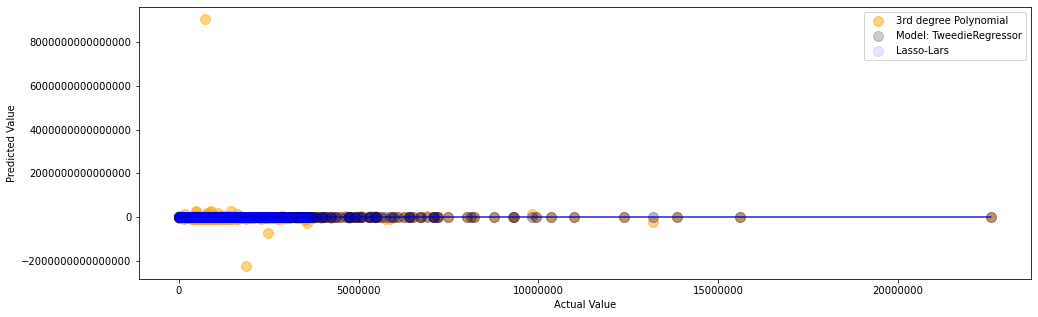

In [53]:
err(y_validate)

In [54]:
def er(y_validate):
    # Plot
    plt.figure(figsize=(16,5))
    plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
                alpha=0.5, color="orange", s=100, label="3rd degree Polynomial")
    plt.plot(y_validate.tax_value, y_validate.pred_mean, alpha=.3, color="black", label='_nolegend_')
    plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue")
    plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
                 alpha=.2, color="teal", s=100, label="Model: TweedieRegressor")
    plt.scatter(y_validate.tax_value, y_validate.pred_lars, 
                alpha=.1, color="blue", s=100, label="Lasso-Lars")
    plt.ticklabel_format(style='plain')

    plt.legend()
    plt.xlim(-100000, 10000000)
    plt.ylim(-1000000, 5000000)
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.show()

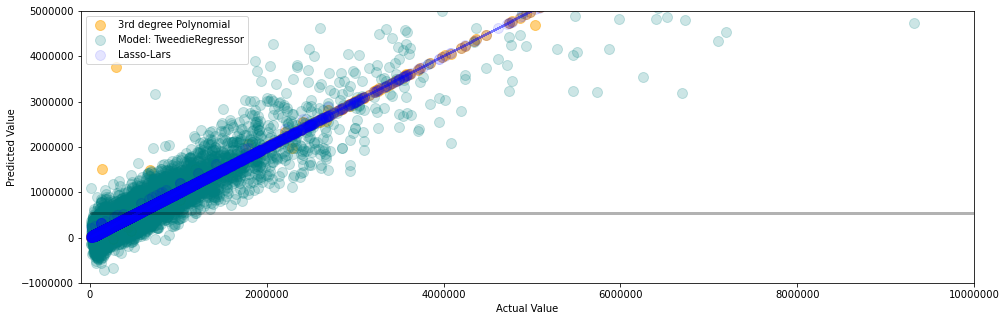

In [55]:
er(y_validate)

In [56]:
#er(y_test)

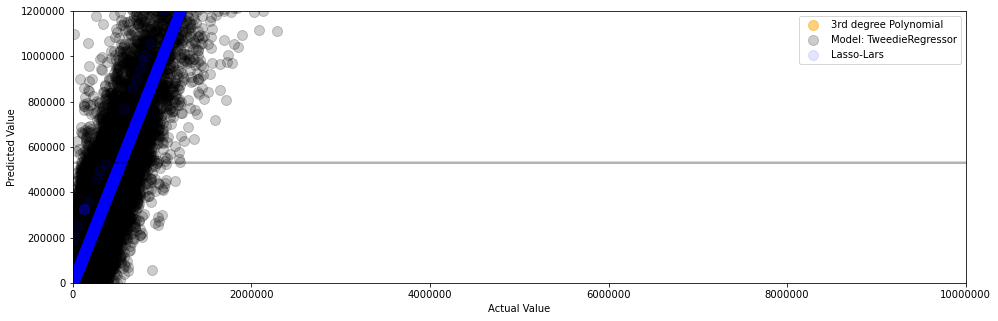

In [57]:
n_error(y_validate)

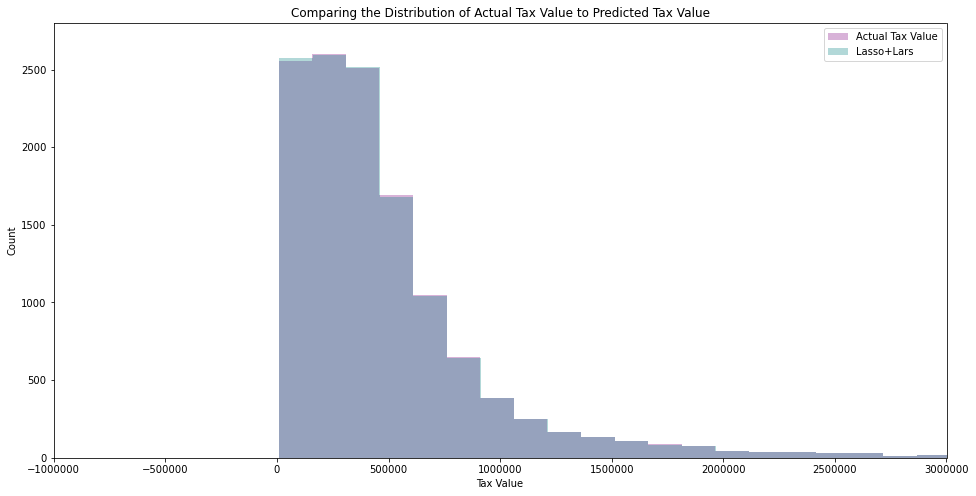

In [76]:
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='purple', alpha=0.3, label="Actual Tax Value", bins=150)
#plt.hist(y_validate.pred_lm, color='blue', alpha=0.3, label="3rd Degree Polynomial Model", bins=150)
plt.hist(y_validate.pred_lars, color='teal', alpha=0.3, label="Lasso+Lars", bins=150)
#plt.hist(y_validate.pred_glm, color='black', alpha=0.2, label="Tweedie", bins=150)
plt.xlabel("Tax Value")
plt.ylabel("Count")
plt.title("Comparing the Distribution of Actual Tax Value to Predicted Tax Value")
plt.ticklabel_format(style='plain')
plt.legend()
plt.xlim(-1000000, 3000000)
plt.ylim(0, 2800)
plt.show()

In [59]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

---

### Because LA county comprises over half of the data, is the model 'good' to use for the other counties?

In [ ]:
#sns.pairplot(data=zillow)
#plt.show()

In [ ]:
Ven_zillow= zillow[zillow.fips == 6111.0]
O_zillow = zillow[zillow.fips == 6059.0]
LA_zillow = zillow[zillow.fips == 6037.0]

Ven_train = train_scaled[train_scaled.fips == 6111.0]
O_train = train_scaled[train_scaled.fips == 6059.0]
LA_train = train_scaled[train_scaled.fips == 6037.0]
Ven_validate = validate_scaled[train_scaled.fips == 6111.0]
O_validate = validate_scaled[train_scaled.fips == 6059.0]
LA_validate = validate_scaled[train_scaled.fips == 6037.0]

In [ ]:
Ven_zillow.head()

In [ ]:
#Ven_zillow..fillna(inplace=True)

## Bonus:

#### Compute the mean(logerror) by zipcode and the overall mean(logerror). 
#### Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [ ]:
zillow.head()

In [ ]:
zillow.columns

#### Compute the overall mean(logerror). 

In [ ]:
print(f'df mean logerror: {zillow.logerror.mean()}')

In [ ]:
zillow.zip.value_counts().mean()

#### Compute the mean(logerror) by zipcode . 

for z in zillow['zip','logerror']:
    print(f'The mean logerror for zip {z}: {zillow.regionidzip.logerror.mean()}')

In [ ]:
len(zillow.logerror.value_counts())

In [ ]:
len(zillow.logerror)

#### Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

---

# Previous model

In [ ]:
zillow = pd.read_csv('zillow_2017_w_transactiondate.csv')
zillow.head()

zillow = wrangle_zillow(zillow)
zillow.head(3)

In [ ]:
from sklearn.model_selection import train_test_split

def scale(df, columns=['bedrooms', 'bathrooms', 'bldg_quality', 'f_sqft', 'zip','lot_size'], target='tax_value', return_scaler=False):
    '''
    Scales train, validate, test and returns scaled versions of each 
    If return_scalar is True, the scaler object will be returned as well
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=0.2, random_state=248)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=248)

    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = pd.DataFrame(train[target])

    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = pd.DataFrame(validate[target])

    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = pd.DataFrame(test[target])
    
    # make copies
    train_scaled = X_train.copy()
    validate_scaled = X_validate.copy()
    test_scaled = X_test.copy()
    # Make the scaler
    scaler = MinMaxScaler()
    # Fit it
    scaler.fit(X_train[columns])
    # Apply the scaler:
    train_scaled[columns] = pd.DataFrame(scaler.transform(X_train[columns]),
                                                  columns=X_train[columns].columns.values).set_index([X_train.index.values])
                                                  
    validate_scaled[columns] = pd.DataFrame(scaler.transform(X_validate[columns]),
                                                  columns=X_validate[columns].columns.values).set_index([X_validate.index.values])
    
    test_scaled[columns] = pd.DataFrame(scaler.transform(X_test[columns]),
                                                 columns=X_test[columns].columns.values).set_index([X_test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test

In [ ]:
#train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = scale(zillow)

In [ ]:
#rmse(y_train, y_validate, 'tax_value')

In [ ]:
#pf(train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test, 'tax_value', 3)

In [ ]:
#lasso_lars(train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test, 'tax_value', 0)

In [ ]:
#glm(train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test, 'tax_value', 0, 0)

In [ ]:
#pf_test(train_scaled, y_train, test_scaled, y_test, 'tax_value', 3)

---

### 3. Is the zip code or census tract feature better at predicting value?

In [ ]:
zillow.head()

In [ ]:
def wrangle(df):
    random.seed(248)
    df = df[(df.propertylandusedesc == 'Single Family Residential') | 
            (df.propertylandusedesc == 'Inferred Single Family Residential')]
    # Create a new column for month of transaction
    df['month'] = df['transactiondate'].str[5:7]
    df['transactiondate'] = df['transactiondate'].str[:4]
    # Reassign the df to only the values where the home had a transaction in 2017
    df = df[df.transactiondate == '2017']
    df = df[['parcelid','bathroomcnt', 'bedroomcnt','buildingqualitytypeid', 'calculatedfinishedsquarefeet','fips',
             'lotsizesquarefeet', 'taxvaluedollarcnt', 'censustractandblock']]
    parcelid = df.parcelid
    df = df.drop(columns={'parcelid'})
    df.rename(columns={'bedroomcnt':'bedrooms',
                       'bathroomcnt':'bathrooms', 
                       'calculatedfinishedsquarefeet':'f_sqft', 
                       'taxvaluedollarcnt':'tax_value',
                       'lotsizesquarefeet':'lot_size',
                       'regionidzip':'zip',
                       'buildingqualitytypeid':'bldg_quality'}, inplace=True)
    cols = [col for col in df.columns if col not in ['month', 'fips']]
    
    # Remove outliers
    df = remove_outliers(df, 1.25, df[cols])
    return df

In [ ]:
z1 = wrangle(zillow)

In [ ]:
z1

In [ ]:
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = scale(z1, columns=['bathrooms', 
                                                                                             'bedrooms', 
                                                                                             'bldg_quality', 
                                                                                             'f_sqft', 
                                                                                             'lot_size',
                                                                                             'fips', 
                                                                                             'censustractandblock'], target='tax_value')

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled.isnull().sum()

In [ ]:
X_train_scaled.describe().T

In [ ]:
X_train_scaled.bldg_quality.fillna(0.369029	,inplace=True)
X_train_scaled.f_sqft.fillna(0.435660,inplace=True)
X_train_scaled.lot_size.fillna(0.450571,inplace=True)
X_train_scaled.censustractandblock.fillna(0.196616,inplace=True)

In [ ]:
X_train_scaled.isnull().sum()

In [ ]:
y_train.isnull().sum()

In [ ]:
X_validate_scaled.isnull().sum()

In [ ]:
X_validate_scaled.describe().T

In [ ]:
X_validate_scaled.bldg_quality.fillna(0.367039,inplace=True)
X_validate_scaled.f_sqft.fillna(0.434347,inplace=True)
X_validate_scaled.lot_size.fillna(0.448731,inplace=True)
X_validate_scaled.censustractandblock.fillna(0.201206,inplace=True)

In [ ]:
X_validate_scaled.isnull().sum()

In [ ]:
y_validate.isnull().sum()

In [ ]:
y_validate.tax_value.mean()

In [ ]:
y_validate.fillna(366325.48,inplace=True)

In [ ]:
y_validate.isnull().sum()

In [ ]:
X_test_scaled.isnull().sum()

In [ ]:
X_test_scaled.describe().T

In [ ]:
X_test_scaled.bldg_quality.fillna(0.371578,inplace=True)
X_test_scaled.f_sqft.fillna(0.435920,inplace=True)
X_test_scaled.lot_size.fillna(0.450781,inplace=True)
X_test_scaled.censustractandblock.fillna(0.190951,inplace=True)

In [ ]:
X_test_scaled.isnull().sum()

In [ ]:
y_test.isnull().sum()

In [ ]:
rmse(y_train, y_validate, 'tax_value')

In [ ]:
pf(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'tax_value', 3)

In [ ]:
lasso_lars(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'tax_value', 1)

In [ ]:
glm(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'tax_value', 0, 0)

In [ ]:
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='purple', alpha=0.3, label="Actual Tax Value", bins=150)
#plt.hist(y_validate.pred_lm, color='blue', alpha=0.3, label="3rd Degree Polynomial Model", bins=150)
plt.hist(y_validate.pred_lars, color='teal', alpha=0.3, label="Lasso+Lars", bins=150)
plt.hist(y_validate.pred_glm, color='black', alpha=0.2, label="Tweedie", bins=150)
plt.xlabel("Tax Value")
plt.ylabel("Count")
plt.title("Comparing the Distribution of Actual Tax Value to Predicted Tax Value")
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,5))
plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
            alpha=0.5, color="orange", s=100, label="3rd degree Polynomial")
plt.plot(y_validate.tax_value, y_validate.pred_mean, alpha=.3, color="black", label='_nolegend_')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue")
plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
             alpha=.2, color="black", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.pred_lars, 
            alpha=.1, color="blue", s=100, label="Lasso-Lars")
plt.ticklabel_format(style='plain')

plt.legend()
plt.xlim(0, 1250000)
plt.ylim(0, 1200000)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.show()

---

# Making bins

In [ ]:
zillow.head()

In [ ]:
zillow = zillow[zillow.propertylandusedesc == 'Single Family Residential']
zillow['month'] = zillow['transactiondate'].str[5:7]
zillow['transactiondate'] = zillow['transactiondate'].str[:4]
#zillow = zillow[zillow.transactiondate == '2017']

In [ ]:
zillow = zillow[['parcelid','bathroomcnt', 'bedroomcnt','buildingqualitytypeid', 'calculatedfinishedsquarefeet','fips',
                 'lotsizesquarefeet', 'regionidzip', 'taxvaluedollarcnt', 'month', 'heatingorsystemtypeid', 'latitude',
                 'longitude', 'rawcensustractandblock', 'censustractandblock', 'roomcnt', 'unitcnt', 'yearbuilt',
                 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'logerror']]
parcelid = zillow.parcelid
zillow = zillow.drop(columns={'parcelid'})
zillow.rename(columns={'bedroomcnt':'bedrooms',
                   'bathroomcnt':'bathrooms', 
                   'calculatedfinishedsquarefeet':'f_sqft', 
                   'taxvaluedollarcnt':'tax_value',
                   'lotsizesquarefeet':'lot_size',
                   'regionidzip':'zip',
                   'buildingqualitytypeid':'bldg_quality'}, inplace=True)

In [ ]:
zillow.head()

In [ ]:
train, validate, test = split(zillow)

In [ ]:
train

In [ ]:
train.isnull().sum()

In [ ]:
for col in train:
    print(train[col].isnull().sum())
    print(train[col].median())
    print(train[col].mean())
    print(train[col].mode())
    print('-----')

In [ ]:
train.bldg_quality.fillna(6.0, inplace=True)
train.f_sqft.fillna(1660.0, inplace=True)
train.lot_size.fillna(6848.0, inplace=True)
train.zip.fillna(96615.0, inplace=True)
train.tax_value.fillna(373124.0, inplace=True)
train.heatingorsystemtypeid.fillna(2.0, inplace=True)
train.censustractandblock.fillna(60376203032005.0, inplace=True)
train.unitcnt.fillna(1.0, inplace=True)
train.yearbuilt.fillna(1961.0, inplace=True)
train.structuretaxvaluedollarcnt.fillna(131779.0, inplace=True)
train.landtaxvaluedollarcnt.fillna(0.025063, inplace=True)
train.taxamount.fillna(4644.0, inplace=True)
train.calculatedbathnbr.fillna(2.0, inplace=True)

In [ ]:
train.head()

In [ ]:
for col in train:
    print(sns.histplot(data=train, x=col))
    plt.show()

In [ ]:
sns.relplot(data=train, x='bedrooms', y='bldg_quality',
            s=100)

In [ ]:
sns.relplot(data=train, x='logerror', y='bedrooms')

In [ ]:
for col in train:
    print(f'Relationship of logerror and {col}')
    plt.figure(figsize=(16,5))
    sns.relplot(data=train, x=col, y='logerror')
    plt.show()

In [ ]:
#stats.levene()